In [1]:
import disentangler as dt
from disentangler.dependencies import *
from scvi.model import SCANVI, SCVI

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [2]:
rna_data = dt.bonemarrow.utils.load_GEX_data()

### Load models

In [3]:
sc.tl.pca(rna_data, use_highly_variable=True, n_comps = 50)

In [5]:
import torch

In [4]:
mira_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA + '2')
mira_no_correction = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA_NO_CORRECTION)
scvi_model = SCVI.load(dt.bonemarrow.config.SCVI, adata=rna_data)
scanvi_model = SCANVI.load(dt.bonemarrow.config.SCANVI, adata = rna_data)

ModuleNotFoundError: No module named 'mira.topic_model.dirichlet_model'

### Save scanorama matrices

In [182]:
from scib.utils import split_batches

In [ ]:
split, categories = split_batches(rna_data.copy(), 'batch', return_categories=True)

In [ ]:
!mkdir -p data/bonemarrow/scanorama
!mkdir -p data/bonemarrow/scanorama/mats
!mkdir -p data/bonemarrow/scanorama/bcs

In [ ]:
import os
from scipy import sparse

In [ ]:
for i, s in enumerate(split):
    sparse.save_npz(
        os.path.join('data/bonemarrow/scanorama/mats/', 'mat_{}.npz'.format(str(i))),
        s.X
    )
    
    with open('data/bonemarrow/scanorama/bcs/bcs_{}.txt'.format(str(i)),'w') as f:
        print(*s.obs_names, file = f, sep = '\n')

In [24]:
with open('data/bonemarrow/scanorama/genes.txt','w') as f:
    print(*rna_data.var_names, file = f, sep = '\n')

### Run scanorama

In [ ]:
scanorama = pd.read_csv('data/bonemarrow/scanorama/scanorama_dimred.tsv', sep = '\t')\
    .set_index('Unnamed: 0')

In [ ]:
rna_data.obsm['X_scanorama'] = scanorama.loc[rna_data.obs_names].values

### Calculate latent spaces

In [ ]:
from scanpy.external.pp import mnn_correct

In [183]:
split, categories = split_batches(rna_data.copy(), 'batch', return_categories=True)

In [ ]:
o = mnn_correct(*split)

In [ ]:
mira_no_correction.predict(rna_data, add_key='X_no_correction_topics', add_cols=False)

In [ ]:
mira_no_correction.get_umap_features(rna_data, box_cox=0.1, 
                                     key = 'X_no_correction_topics',
                                    add_key = 'MIRA_no_correction_umap_features')

mira_no_correction.get_umap_features(rna_data, box_cox=0.5, 
                                     key = 'X_no_correction_topics',
                                    add_key = 'X_no_correction_umap_features')

In [ ]:
mira_model.predict(rna_data)
mira_model.get_umap_features(rna_data, box_cox=0.1)
rna_data.obsm['MIRA_umap_features'] = rna_data.obsm['X_umap_features'].copy()
mira_model.get_umap_features(rna_data, box_cox = 0.5)

In [ ]:
rna_data.obsm['scvi_features'] = scvi_model.get_latent_representation(rna_data)
rna_data.obsm['scanvi_features'] = scanvi_model.get_latent_representation(rna_data)

In [ ]:
import harmonypy as hm
ho = hm.run_harmony(rna_data.obsm['X_pca'][:,:50], rna_data.obs, ['Site','DonorNumber'])

rna_data.obsm['X_harmony'] = ho.Z_corr.T

# Calculate silhouettes

In [ ]:
joint_celltype_batchcols = rna_data.obs['cell_type'].astype(str) \
    + ":" + rna_data.obs['Site'].astype(str)

In [ ]:
latent_spaces = ['X_umap_features', 'X_no_correction_umap_features','scvi_features', 
                 'scanvi_features','X_harmony','X_pca','X_scanorama']
umap_spaces = ['MIRA_umap_features', 'MIRA_no_correction_umap_features'] + latent_spaces[2:]

In [ ]:
from sklearn.metrics import silhouette_samples

In [ ]:
for space in latent_spaces:
    
    batch = \
        silhouette_samples(
            rna_data.obsm[space],
            joint_celltype_batchcols,
        )
    
    
    cell = \
        silhouette_samples(
            rna_data.obsm[space],
            rna_data.obs_vector('cell_type'),
        )
    
    rna_data.obs[space + '_batch-silhouette'] = batch
    rna_data.obs[space + '_silhouette'] = cell
    
    print(space + ':', np.mean(cell), np.mean(batch))

In [15]:
for space in umap_spaces:
    sc.pp.neighbors(rna_data, use_rep = space, metric = 'manhattan' if space == 'MIRA_umap_features' else 'euclidean')
    sc.tl.umap(rna_data, min_dist = 0.1, negative_sample_rate = 3)
    rna_data.obsm[space + '_UMAP'] = rna_data.obsm['X_umap'].copy()

## Correctly-sized UMAPsgeneral_umap_kwargs

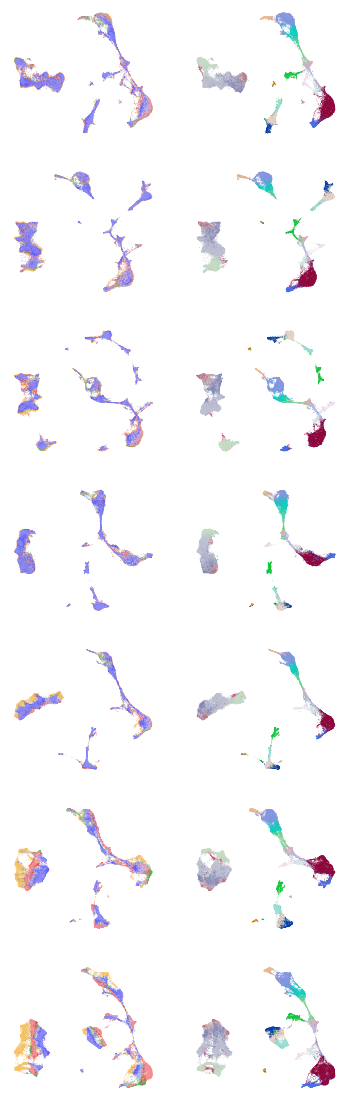

In [20]:
fig, ax = plt.subplots(7,2,figsize=(6,20))#, gridspec_kw = dict(hspace = 0.4, wspace = 0.2))

order = ['MIRA_umap_features','scvi_features', 
                 'scanvi_features','X_harmony','X_scanorama','X_pca','MIRA_no_correction_umap_features',]
general_umap_kwargs = dict(
                  legend_loc='none', title = '', show = False, alpha = 1., frameon=False, s = 1.5)

celltype_umap_kwargs = dict(color = 'cell_type', palette= dt.bonemarrow.colors.CELL_PALETTE, **general_umap_kwargs)

batch_umap_kwargs = dict(color = 'batch', palette= dt.bonemarrow.colors.BATCH_PALETTE, **general_umap_kwargs)

for row, basis in enumerate(order):
    sc.pl.embedding(rna_data, basis = basis + '_UMAP', **celltype_umap_kwargs, ax = ax[row,1])
    sc.pl.embedding(rna_data, basis = basis + '_UMAP', **batch_umap_kwargs, ax = ax[row,0])
    #ax[row,1].set_aspect('equal')
    #ax[row,0].set_aspect('equal')
    if row in [5,2, 4]:
        ax[row,0].axes.invert_yaxis()
        ax[row,1].axes.invert_yaxis()
        
    
plt.savefig('sup1/all_umaps.png', dpi = 300, bbox_inches= 'tight')

## Front-page UMAPs

## Single UMAPs

In [21]:
!mkdir -p figure1
!mkdir -p figure1/umaps

In [ ]:
for basis in umap_spaces:
    
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    sc.pl.embedding(rna_data, color = 'cell_type', ax = ax, frameon=False, s = 2, palette= dt.bonemarrow.colors.CELL_PALETTE,
              legend_loc='none', title = '', show = False, alpha = 1., basis = basis + '_UMAP')
    ax.set_aspect('equal')
    plt.savefig('figure1/umaps/{}_celltypes.png'.format(basis), dpi = 300, bbox_inches = 'tight')

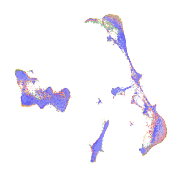

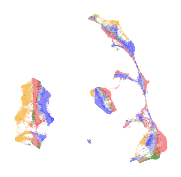

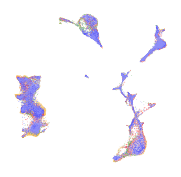

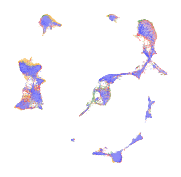

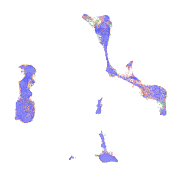

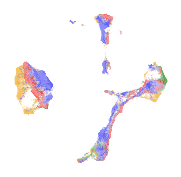

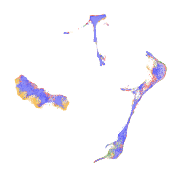

In [89]:
for basis in umap_spaces:
    
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    sc.pl.embedding(rna_data, color = 'batch', ax = ax, frameon=False, s = 2, palette= dt.bonemarrow.colors.BATCH_PALETTE,
              legend_loc='none', title = '', show = False, alpha = 1., basis = basis + '_UMAP')
    plt.savefig('figure1/umaps/{}_batch.png'.format(basis), dpi = 300, bbox_inches = 'tight')

In [24]:
!mkdir -p tables

In [ ]:
silhouette_cols = ['X_umap_features_batch-silhouette', 'X_umap_features_silhouette',
        'X_no_correction_umap_features_batch-silhouette', 'X_no_correction_umap_features_silhouette',
       'scvi_features_batch-silhouette', 'scvi_features_silhouette',
       'scanvi_features_batch-silhouette', 'scanvi_features_silhouette',
       'X_harmony_batch-silhouette', 'X_harmony_silhouette',
       'X_pca_batch-silhouette', 'X_pca_silhouette','X_scanorama_batch-silhouette','X_scanorama_silhouette']

silhouettes = rna_data.obs[silhouette_cols].mean(0).to_frame().reset_index()\
    .rename(columns = {'index' : 'space_type', 0 : 'score'})

silhouettes['space'] = list(map(lambda x : '_'.join(x[:-1]), silhouettes['space_type'].str.split('_')))
silhouettes['batch_features'] = silhouettes['space_type'].str.contains('batch')

scores = silhouettes.pivot('space', columns='batch_features', values='score').reset_index()

scores['is_supervised'] = scores.space == 'scanvi_features'

In [ ]:
space_name_map = {
            'X_harmony' : "Harmony",
            'X_no_correction_umap_features' : 'MIRA (no correction)',
            'X_pca' : 'PCA (unintegrated)',
            'X_umap_features' : 'CODA (ours)',
            'scanvi_features' : 'scANVI',
            'scvi_features' : 'scVI',
            'X_scanorama': 'Scanorama',
        }

In [ ]:
scores['is_correcting'] = [True, False, False, True, True, True,True]
scores['space'] = scores['space'].map(space_name_map)
scores.rename(columns = {
        False : 'cell type silhouette', 
        True : 'batch silhouette',
        'space' : 'method',
    }).set_index('method')\
    .to_csv('tables/bonemarrow_silhoeutte_scores.tsv', sep = '\t')

In [ ]:
ax = fig, ax = plt.subplots(1,1,figsize=(5,5))

sns.scatterplot(
    data = scores,
    y = False,
    x = True,
    s = 450,
    palette= {True : 'white', False : 'black'},
    edgecolor = 'black',
    linewidth = 3,
    hue = 'is_supervised',
    ax  = ax,
    legend=False
)

ax.set_xmargin(0.3)
ax.set_ymargin(0.3)
ax.axis('equal')
ax.set(ylabel = 'Cell type silhouette', xlabel = 'Batch silhouette',
      xticks = [-0.1, -0.03, 0.04], yticks = [0.06, 0.12, 0.18])
sns.despine()

#plt.savefig('figure1/silhouette_scores.svg')

In [16]:
from scib.metrics import ilisi_graph, clisi_graph, isolated_labels

In [ ]:
ilisi_scores = []

for i, space in enumerate(latent_spaces):
    metric = 'euclidean'
    if i < 2:
        metric = 'manhattan'
    
    sc.pp.neighbors(rna_data, use_rep=space, metric= metric)
    
    cscore, percell_cscore = clisi_graph(rna_data, 'Site', 'cell_type')#, subsample=20)
    iscore, percell_iscore = ilisi_graph(rna_data, 'Site')#, subsample = 20)
    
    scores = (space, cscore ,iscore)
    ilisi_scores.append(scores)
    
    rna_data.obs[space + '_cLISI'] = percell_cscore
    rna_data.obs[space + '_iLISI'] = percell_iscore
    print(*scores, sep = '\t')
    

X_umap_features	0.9937106067389514	0.5387983741928982
X_no_correction_umap_features	0.9941137939938529	0.10568808796737583
scvi_features	0.9870844373684312	0.5335377856578004
scanvi_features	0.9957046218181311	0.5058270089991486
X_harmony	0.9878029372681024	0.551625934478702
X_pca	0.9916358113960515	0.16702133222012291


In [101]:
ilisi_scores_df = pd.DataFrame(ilisi_scores, columns=['method', 'cell type iLISI', 'batch iLISI'])
ilisi_scores_df['is_correcting'] = [True, False, True, True, True, False,True]
ilisi_scores_df['is_supervised'] = [False, False, False, True, False, False,False]

ilisi_scores_df['method'] = ilisi_scores_df.method.map(space_name_map)
ilisi_scores_df.set_index('method').to_csv('tables/bonemarrow_iLISI_scores.tsv',sep = '\t')

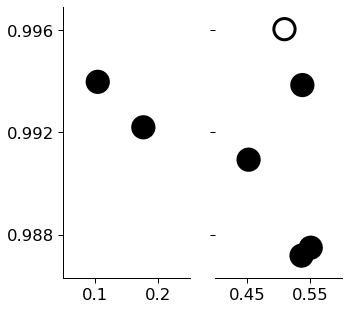

In [125]:
ax = fig, ax = plt.subplots(1,2,figsize=(5,5), sharey=True)

for ax_ in ax:
    sns.scatterplot(
        ax = ax_,
        data = ilisi_scores_df,
        y = 'cell type iLISI',
        x = 'batch iLISI',
        s = 450,
        palette= {True : 'white', False : 'black'},
        edgecolor = 'black',
        linewidth = 3,
        hue = 'is_supervised',
        legend=False
    )
    
ax[0].set_xlim(0.05,0.25)  # outliers only
ax[1].set_xlim(0.4,0.6)  # most of the data

# hide the spines between ax and ax2
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_linewidth(1)
ax[1].spines['bottom'].set_linewidth(1)
ax[0].spines['bottom'].set_linewidth(1)
ax[0].set_ymargin(0.1)
ax[0].set(xticks = [0.1,0.2], yticks = [0.988,0.992,0.996])
ax[1].set(xticks = [0.45, 0.55])


# increase tick width
ax[0].tick_params(width=1, length = 5)
ax[1].tick_params(width=1, length = 5)
ax[0].set(ylabel = '', xlabel = '')
ax[1].set(ylabel = '', xlabel = '')
plt.savefig('sup1/bonemarrow_RNA_ilisi.svg')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,20))

i = 0
for cluster in ['Normoblast',
 'Erythroblast',
 'Proerythroblast',
 'MK/E prog',
 'HSC',
 'G/M prog',
 'cDC2',
 'pDC',
 'CD14+ Mono',
 'CD16+ Mono',
 'ID2-hi myeloid prog',
 'Lymph prog',
 'Transitional B',
 'Naive CD20+ B',
 'Plasma cell',
 'B1 B',
 'CD4+ T activated',
 'CD4+ T naive',
 'CD8+ T',
 'CD8+ T naive',
 'NK',
 'ILC'][::-1]:
    
    color = dt.bonemarrow.colors.CELL_PALETTE[cluster]
    
    scores = rna_data[rna_data.obs.cell_type == cluster].obs['X_umap_features_silhouette']
    competitor_scores = rna_data[rna_data.obs.cell_type == cluster].obs['scvi_features_silhouette']
    
    diff= 0
    if len(scores) < 1000:
        diff = (1000 - len(scores))//2
    
    i+=diff
    
    plt.fill_betweenx(
        np.arange(i, i + len(scores)),
        np.sort(scores),
        color = 'black',
        alpha = 1.,
    )
    
    
    plt.fill_betweenx(
        np.arange(i, i + len(scores)),
        np.sort(competitor_scores),
        color = 'darkgrey',
        alpha = 1.,
    )
    
    
    i+=len(scores) + diff
    
    ax.text(-1, i - len(scores)//2, cluster, 
            ha = 'right', va = 'center')
    
sns.despine()
#ax.set(xlim = (-1,1), yticks = [], xticks = [-1, 0, 1])
ax.spines['left'].set_visible(False)
#plt.savefig('figure1/silhouette_cascade_plot.svg', bbox_inches = 'tight',
#               dpi = 300)

In [112]:
rna_data.obs['diff_silhouette'] = -rna_data.obs['X_umap_features_cLISI'] + rna_data.obs['scvi_features_cLISI']
rna_data.obs['diff_silhouette_2'] = -rna_data.obs['scvi_features_cLISI'] + rna_data.obs['X_umap_features_cLISI']

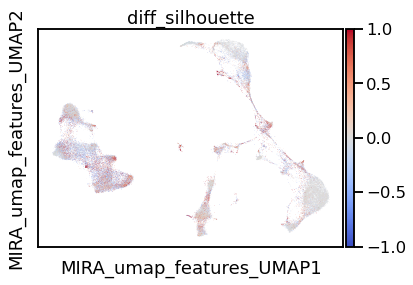

In [52]:
sc.pl.embedding(rna_data, color = 'diff_silhouette',
                basis = 'MIRA_umap_features_UMAP', color_map='coolwarm',
               vmin = -1, vmax = 1, s = 0.5)

In [47]:
import matplotlib
matplotlib.rc('font',size=20)

In [106]:
rna_data.obs[list(rna_data.obs.columns[rna_data.obs.columns.str.contains('cLISI')])].median(0)\
    .sort_values()

scanvi_features_cLISI                  1.090203
X_no_correction_umap_features_cLISI    1.123610
X_umap_features_cLISI                  1.132077
X_pca_cLISI                            1.175648
X_scanorama_cLISI                      1.200629
X_harmony_cLISI                        1.256138
scvi_features_cLISI                    1.271227
dtype: float64

In [110]:
means = -1*rna_data.obs[list(rna_data.obs.columns[rna_data.obs.columns.str.contains('cLISI')]) + ['cell_type']]\
    .groupby('cell_type').median()

fig, ax = plt.subplots(1,1,figsize=(5,10))
matplotlib.rc('font',size=7)
sns.heatmap(means, square=True, ax = ax, )

In [114]:
tcells = rna_data[rna_data.obs.cell_type.str.contains('CD\d+\+ T') \
                & (rna_data.obsm['MIRA_umap_features_UMAP'][:,0] < 2) & \
                 (rna_data.obsm['scvi_features_UMAP'][:,0] < 2)].copy()

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
/tmp/ipykernel_72104/446144072.py:1: DeprecationWarning: invalid escape sequence \d
  tcells = rna_data[rna_data.obs.cell_type.str.contains('CD\d+\+ T') \


In [172]:
d = rna_data.obs[['X_umap_features_cLISI','scvi_features_cLISI','cell_type']].melt(id_vars = 'cell_type',
                                                                            var_name='method', value_name='cLISI')
d['cLISI'] = -1*d['cLISI']

[(-3.0, 0.0)]

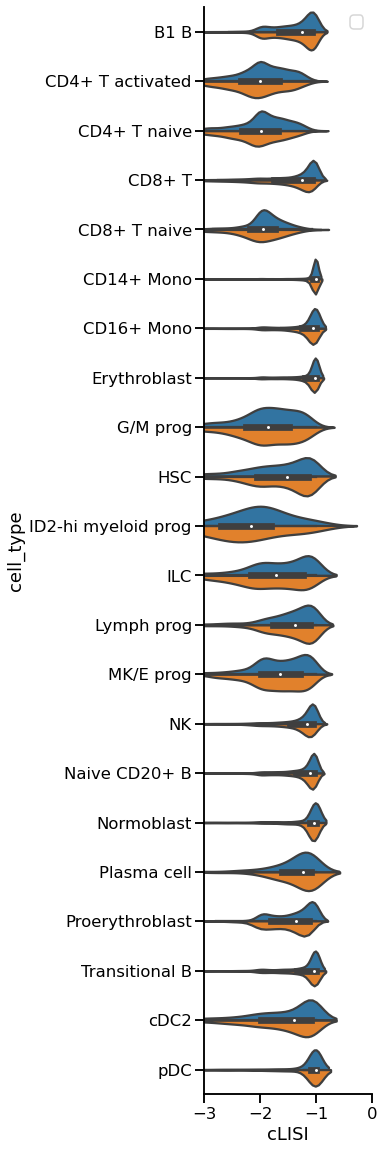

In [175]:
fig, ax = plt.subplots(1,1,figsize=(3,20))
ax = sns.violinplot(
    ax = ax,
    data = d,
    y = 'cell_type',
    x = 'cLISI',
    hue = 'method',
    split = True,
    #cut = 0,
)
sns.despine()
ax.legend([],[])
ax.set(xlim = (-3,0))

<AxesSubplot:xlabel='scvi_features_UMAP1', ylabel='scvi_features_UMAP2'>

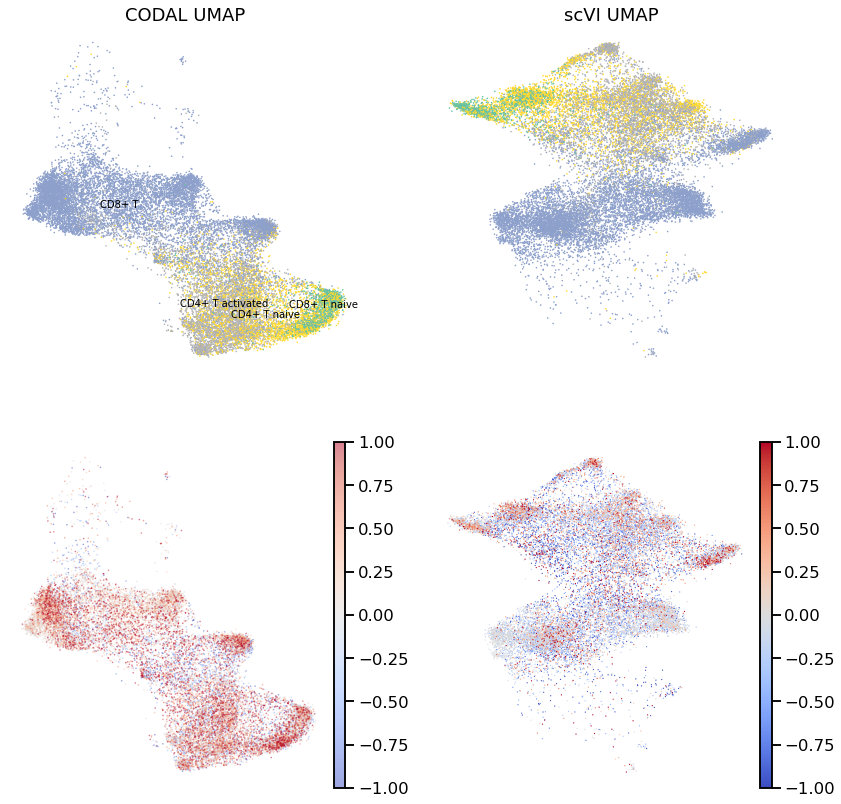

In [118]:
fig, ax = plt.subplots(2,2,figsize=(14,14))
sc.pl.embedding(tcells, color = 'cell_type', ax = ax[0,0], frameon=False, s = 10, palette= 'Set2_r',
              legend_loc= 'on data', legend_fontsize = 10, legend_fontweight=300, 
               show = False, alpha = 1., basis = 'MIRA_umap_features_UMAP',
               title = 'CODAL UMAP')

sc.pl.embedding(tcells, color = 'cell_type', ax = ax[0,1], s = 10, #palette= dt.bonemarrow.colors.CELL_PALETTE,
             legend_loc='none',#legend_loc= 'on data', legend_fontsize = 10, legend_fontweight=300, 
                show = False, alpha = 1., basis = 'scvi_features_UMAP', frameon=False,
               title = 'scVI UMAP')


sc.pl.embedding(tcells, color = 'diff_silhouette', ax= ax[1,0], show = False,
           color_map='coolwarm', vmin = -1, vmax = 1, title = '',
          frameon=False, basis = 'MIRA_umap_features_UMAP', s= 10, alpha = 0.5)

sc.pl.embedding(tcells, color = 'diff_silhouette_2', ax= ax[1,1], show = False,
           color_map='coolwarm', vmin = -1, vmax = 1, title = '',
          frameon=False, basis = 'scvi_features_UMAP')

In [89]:
mira_model.impute(tcells)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/78 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed


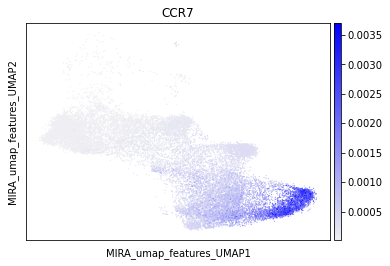

In [91]:
sc.pl.embedding(tcells, color_map = sns.color_palette('light:blue',as_cmap=True),
           color = 'CCR7', basis = 'MIRA_umap_features_UMAP',
               layer='imputed')

## Topic analysis

In [36]:
from mira.plots.base import map_plot, plot_umap, map_colors

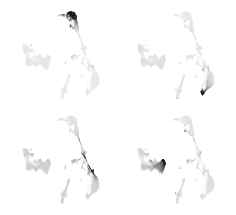

In [77]:
def topic_umap(ax, topic):
    
    ax = plot_umap(
        rna_data.obsm['MIRA_umap_features_UMAP'],
        rna_data.obs_vector(topic),
        palette=sns.color_palette('light:black', as_cmap=True),
        figsize=(5,5),
        size = 0.1,
        add_legend=False,
        vmin=-0.025,
        ax = ax,
        title = None,#'Topic ' + topic.split('_')[-1],
        edgecolor = None,
        linewidth = 0.
    )
    ax.set_xmargin(0.2)
    ax.set_xmargin(0.2)

map_plot(topic_umap, [['topic_' + str(x)] for x in [1, 13, 5, 0]], plots_per_row=2, height=3, aspect=1.1)
plt.savefig('figure1/selected_topics.png', bbox_inches = 'tight', dpi = 300)

In [38]:
import matplotlib
matplotlib.rc('font', size=7)

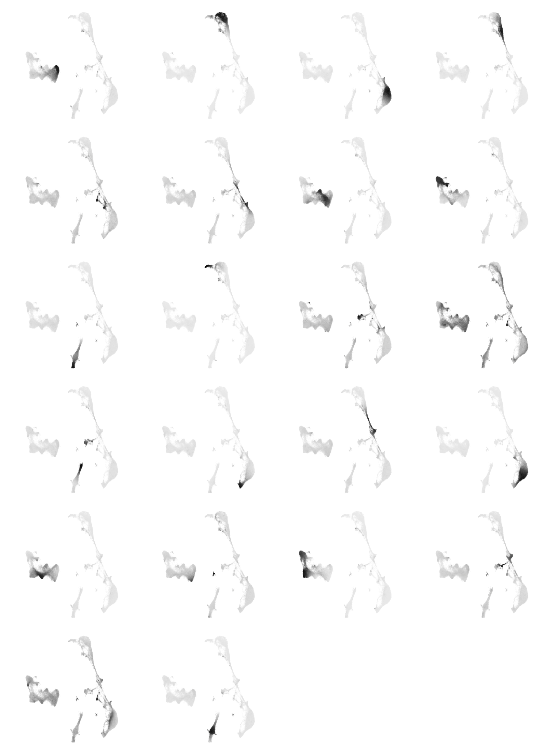

In [79]:
map_plot(topic_umap, [[x] for x in mira_model.topic_cols], plots_per_row=4, height=1.75, aspect=1.1)
plt.savefig('sup1/RNA_topics.png', bbox_inches = 'tight', dpi = 300)

### Colorbars

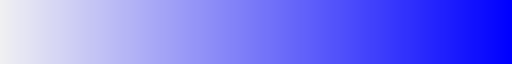

In [117]:
sns.color_palette('light:blue', as_cmap=True)


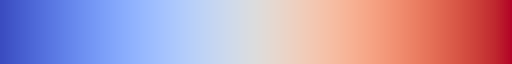

In [125]:
sns.color_palette('coolwarm', as_cmap=True)


In [ ]:
len(mira_model.features)

3452